#### This file has the code to finetune a geneformer model for disease classification.
#### The evaluation is a 1-step evaluation rather than k-fold

### Step 0 Imports and Global Vars

In [1]:
import pickle, datetime, subprocess, os, torch
import numpy as np
import pandas as pd
import perturber_utils as pu
import evaluation_utils as eu
import classifier_utils as cu
from classifier import Classifier
from pathlib import Path

import logging
logger = logging.getLogger(__name__)

from collator_for_classification import DataCollatorForCellClassification
from transformers import Trainer

output_prefix = "test"
output_dir = "./preprocessed_dataset"
classifier = "cell"
# previously balanced splits with prepare_data and validate functions
# argument attr_to_split set to "individual" and attr_to_balance set to ["disease","lvef","age","sex","length"]
train_ids = ["1447", "1600", "1462", "1558", "1300", "1508", "1358", "1678", "1561", "1304", "1610", "1430", "1472", "1707", "1726", "1504", "1425", "1617", "1631", "1735", "1582", "1722", "1622", "1630", "1290", "1479", "1371", "1549", "1515"]
eval_ids = ["1422", "1510", "1539", "1606", "1702"]
test_ids = ["1437", "1516", "1602", "1685", "1718"]

train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids+eval_ids,
                            "test": test_ids}

training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}                            

### Step 1 Prepare the data

This step should be ran for only once to get the data ready.

In [3]:
# # select the cell types
# filter_data_dict={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]}

# # training_args and cc = Classifier initialization is for the purpose of doing the data preparations (cc.prepare_data)
# training_args = {
#     "num_train_epochs": 0.9,
#     "learning_rate": 0.000804,
#     "lr_scheduler_type": "polynomial",
#     "warmup_steps": 1812,
#     "weight_decay":0.258828,
#     "per_device_train_batch_size": 12,
#     "seed": 73,
# }
# cc = Classifier(classifier="cell",
#                 cell_state_dict = {"state_key": "disease", "states": "all"},
#                 filter_data=filter_data_dict,
#                 training_args=training_args,
#                 max_ncells=None,
#                 freeze_layers = 2,
#                 num_crossval_splits = 1,
#                 forward_batch_size=200,
#                 nproc=1)


# # Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
# cc.prepare_data(input_data_file="./human_dcm_hcm_nf.dataset",
#                 output_directory=output_dir,
#                 output_prefix=output_prefix,
#                 split_id_dict=train_test_id_split_dict)

### Step 2 Get the data and model ready

#### 1) Data preparation

In [2]:
train_valid_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": eval_ids}

prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset"                            

##### Load data and prepare output directory #####
# load numerical id to class dictionary (id:class)
with open(f"{output_dir}/{output_prefix}_id_class_dict.pkl", "rb") as f:
    id_class_dict = pickle.load(f)
class_id_dict = {v: k for k, v in id_class_dict.items()}

# load previously filtered and prepared data
nproc = 1 # can be more than 1, up to the number of processers of the cpu
data = pu.load_and_filter(None, nproc, prepared_input_data_file)
data = data.shuffle(seed=42)  # reshuffle in case users provide unshuffled data

# define output directory path
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
if output_dir[-1:] != "/":  # add slash for dir if not present
    output_dir = output_dir + "/"
output_dir_ = f"{output_dir}{datestamp}_geneformer_{classifier}Classifier_{output_prefix}/"
subprocess.call(f"mkdir {output_dir_}", shell=True)

# get number of classes for classifier
num_classes = len(id_class_dict)

# get the train/eval split ready
results = []
all_conf_mat = np.zeros((num_classes, num_classes))

data_dict = dict()
data_dict["train"] = pu.filter_by_dict(
    data,
    {train_valid_id_split_dict["attr_key"]: train_valid_id_split_dict["train"]},
    nproc,
)
data_dict["test"] = pu.filter_by_dict(
    data,
    {train_valid_id_split_dict["attr_key"]: train_valid_id_split_dict["eval"]},
    nproc,
)

train_data = data_dict["train"]
eval_data = data_dict["test"]

# Further clean up the data: dropping columns 8 to 3
train_data, eval_data = cu.validate_and_clean_cols(
            train_data, eval_data, classifier)

# output a data summary on training
label_set = set(train_data["label"])
print(f"Training data has {len(train_data)} rows,\
with labels being {label_set}, indicating {len(id_class_dict)} diseases: {id_class_dict}")  

# # output a data summary on evaluation\
label_set = set(eval_data["label"])
print(f"Evaluation data has {len(eval_data)} rows, \
with labels being {label_set}, indicating {len(id_class_dict)} diseases: {id_class_dict}")              

Training data has 93589 rows,with labels being {0, 1, 2}, indicating 3 diseases: {0: 'dcm', 1: 'nf', 2: 'hcm'}
Evaluation data has 21778 rows, with labels being {0, 1, 2}, indicating 3 diseases: {0: 'dcm', 1: 'nf', 2: 'hcm'}


#### 2) Re-encode the data

In [4]:
# """
# Important:
# 1. I will use the information in train_data["input_ids"] to train a new tokenizer
# """
# tokenized_dataset = train_data["input_ids"]

# # start the training
# final_vocab_size = 40000
# tokenizer_path = os.getcwd()+"/saved_tokenizers"
# tokenizer_list = os.listdir(tokenizer_path)
# if tokenizer_list == []:
#     print("Train from the beginning...")
#     from Tokenization import GeneTokenizer
#     tokenizer = GeneTokenizer()
#     tokenizer.train(tokenized_dataset,final_vocab_size)
# else:
#     import re
#     tokenizer_list.sort(key=lambda f: int(re.sub('\D','',f)))
#     most_current_tokenizer = tokenizer_list[-1]
#     print(f"Load {most_current_tokenizer}...")
#     import pickle
#     tokenizer = pickle.load(open(tokenizer_path+"/"+most_current_tokenizer,"rb"))
#     tokenizer.train(tokenized_dataset,final_vocab_size)    


# ## make a pickle file and train the tokenizer somewhere else
# tokenized_dataset = train_data["input_ids"]
# pickle.dump(tokenized_dataset,open("train_data_human_dcm_hcm_nf","wb"))
# td = pickle.load(open("train_data_human_dcm_hcm_nf","rb"))
# assert len(tokenized_dataset) == len(td)

"""
2. This is where I can load up my trained tokenizer to re-encode the tokens 
in train_data["input_ids"] and eval_data["input_ids"]
"""

#TBD
#TBD
#TBD

'\n2. This is where I can load up my trained tokenizer to re-encode the tokens \nin train_data["input_ids"] and eval_data["input_ids"]\n'

#### 3) Get the model ready

In [16]:
# 2) get the model ready

iteration_num = 1 # if 1 then no k-fold cross validation
ksplit_output_dir = os.path.join(output_dir, f"ksplit{iteration_num}")

# ensure not overwriting previously saved model
saved_model_test = os.path.join(ksplit_output_dir, "pytorch_model.bin")
if os.path.isfile(saved_model_test) is True:
    logger.error("Model already saved to this designated output directory.")
    raise

# make output directory
subprocess.call(f"mkdir {ksplit_output_dir}", shell=True)

##### Load model and training args #####
model_type = "CellClassifier"
model_directory=r"D:\work\Spring 2024\geneformer\Geneformer\fine_tuned_models\geneformer-6L-30M_CellClassifier_cardiomyopathies_220224"
model = pu.load_model(model_type, num_classes, model_directory, "train")   

classifier_type = "cell"
def_training_args, def_freeze_layers = cu.get_default_train_args(
            model, classifier, train_data, ksplit_output_dir)

if training_args is not None:
    def_training_args.update(training_args)
    logging_steps = round(
        len(train_data) / def_training_args["per_device_train_batch_size"] / 10
    )

def_training_args["logging_steps"] = logging_steps
def_training_args["output_dir"] = ksplit_output_dir

from transformers.training_args import TrainingArguments
training_args_init = TrainingArguments(**def_training_args)


# The number of layers to be frozen for finetuning
def_freeze_layers = 2
if def_freeze_layers > 0:
    modules_to_freeze = model.bert.encoder.layer[:def_freeze_layers]
    for module in modules_to_freeze:
        for param in module.parameters():
            param.requires_grad = False

####################################################
# 3. Here is where I can change the Embedding layer
####################################################
# new_vocab_size = 40000
# d_dimension = 256 # according to the model
# # get the model to cpu
# # model.to("cpu")
# # create a new embedding layer
# new_embedding = torch.nn.Embedding(new_vocab_size,d_dimension,padding_idx=0)
# # get the old embedding
# old_embedding = model.bert.embeddings.word_embeddings.weight.data
# # save old_embedding into new_embedding
# new_embedding.weight.data[:25426,:] = old_embedding
# # let the new_embedding replace the model's current embedding
# model.bert.embeddings.word_embeddings = new_embedding
# # get the model to gpu
# model.to("cuda")

'\n3. Here is where I can change the Embedding and Positional Encoding layers\n'

### Step 3 Finetune the model

In [ ]:
data_collator = DataCollatorForCellClassification()
# create the trainer
trainer = Trainer(
    model=model,
    args=training_args_init,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=eval_data,
    compute_metrics=cu.compute_metrics,
)

#### FINETUNING ####
trainer.train()
trainer.save_model(ksplit_output_dir)

### Step 4 Evaluate the saved model

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


  0%|          | 0/87 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

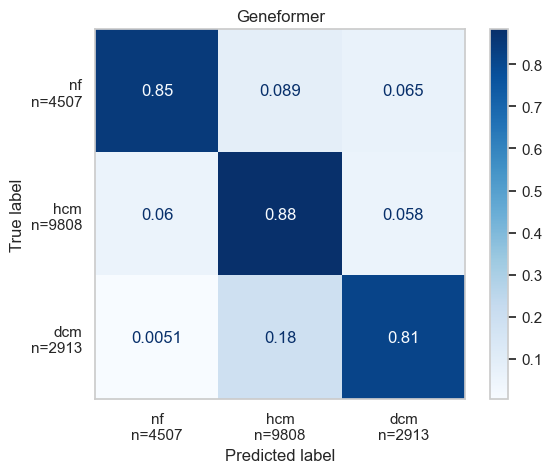

FileNotFoundError: [Errno 2] No such file or directory: '.preprocessed_dataset\\test_conf_mat.pdf'

In [17]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},
                forward_batch_size=200,
                nproc=1)    

all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"./preprocessed_dataset/240408_geneformer_cellClassifier_test/ksplit1/",
        id_class_dict_file=f"./preprocessed_dataset/test_id_class_dict.pkl",
        test_data_file=f"./preprocessed_dataset/test_labeled_test.dataset",
        output_directory="./preprocessed_dataset",
        output_prefix="test",
)

cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory="./preprocessed_dataset",
        output_prefix="test",
        custom_class_order=["nf","hcm","dcm"],
)

In [18]:
all_metrics_test

{'conf_matrix':       dcm    nf   hcm
 dcm  2363    15   535
 nf    293  3812   402
 hcm   567   585  8656,
 'macro_f1': 0.8391126976991137,
 'acc': 0.8608660320408638,
 'all_roc_metrics': None}